# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/data/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/data/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/data/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"Tissue Types: {label_encoder.classes_}")
# Print encoding information

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [11]:
def create_densenet_model(architecture='121', num_classes=4, pretrained=True):
    """Create DenseNet model for bladder tissue classification
    
    Supported architectures: '121', '201'
    """
    if architecture == '121':
        model = models.densenet121(pretrained=pretrained)
    elif architecture == '201':
        model = models.densenet201(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be '121' or '201'")
    
    # Modify the classifier for our number of classes
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DenseNet-121

Training DenseNet-121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 205MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  4.09it/s, Loss=0.6636, Acc=0.7730]


Train Loss: 0.6636 Acc: 0.7730 Macro-F1: 0.7222


Val : 100%|██████████| 10/10 [00:04<00:00,  2.01it/s, Loss=0.6741, Acc=0.7993]


Val Loss: 0.6741 Acc: 0.7993 Macro-F1: 0.7753
✓ New best model saved with validation macro-F1: 0.7753

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.2680, Acc=0.8947]


Train Loss: 0.2680 Acc: 0.8947 Macro-F1: 0.8643


Val : 100%|██████████| 10/10 [00:01<00:00,  7.88it/s, Loss=0.3342, Acc=0.8750]


Val Loss: 0.3342 Acc: 0.8750 Macro-F1: 0.8398
✓ New best model saved with validation macro-F1: 0.8398

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, Loss=0.2736, Acc=0.9161]


Train Loss: 0.2736 Acc: 0.9161 Macro-F1: 0.8916


Val : 100%|██████████| 10/10 [00:01<00:00,  8.37it/s, Loss=0.2321, Acc=0.9145]


Val Loss: 0.2321 Acc: 0.9145 Macro-F1: 0.8713
✓ New best model saved with validation macro-F1: 0.8713

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Loss=0.2628, Acc=0.9104]


Train Loss: 0.2628 Acc: 0.9104 Macro-F1: 0.8822


Val : 100%|██████████| 10/10 [00:01<00:00,  8.59it/s, Loss=0.2568, Acc=0.8849]


Val Loss: 0.2568 Acc: 0.8849 Macro-F1: 0.8377

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.68it/s, Loss=0.1839, Acc=0.9334]


Train Loss: 0.1839 Acc: 0.9334 Macro-F1: 0.9214


Val : 100%|██████████| 10/10 [00:01<00:00,  8.34it/s, Loss=0.4264, Acc=0.8355]


Val Loss: 0.4264 Acc: 0.8355 Macro-F1: 0.7944

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.85it/s, Loss=0.1398, Acc=0.9556]


Train Loss: 0.1398 Acc: 0.9556 Macro-F1: 0.9436


Val : 100%|██████████| 10/10 [00:01<00:00,  8.51it/s, Loss=0.1560, Acc=0.9441]


Val Loss: 0.1560 Acc: 0.9441 Macro-F1: 0.9216
✓ New best model saved with validation macro-F1: 0.9216

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, Loss=0.1865, Acc=0.9359]


Train Loss: 0.1865 Acc: 0.9359 Macro-F1: 0.9088


Val : 100%|██████████| 10/10 [00:01<00:00,  8.75it/s, Loss=0.1665, Acc=0.9441]


Val Loss: 0.1665 Acc: 0.9441 Macro-F1: 0.9142

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.86it/s, Loss=0.0927, Acc=0.9688]


Train Loss: 0.0927 Acc: 0.9688 Macro-F1: 0.9653


Val : 100%|██████████| 10/10 [00:01<00:00,  8.25it/s, Loss=0.0405, Acc=0.9836]


Val Loss: 0.0405 Acc: 0.9836 Macro-F1: 0.9787
✓ New best model saved with validation macro-F1: 0.9787

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.76it/s, Loss=0.0665, Acc=0.9819]


Train Loss: 0.0665 Acc: 0.9819 Macro-F1: 0.9751


Val : 100%|██████████| 10/10 [00:01<00:00,  8.15it/s, Loss=0.0319, Acc=0.9934]


Val Loss: 0.0319 Acc: 0.9934 Macro-F1: 0.9903
✓ New best model saved with validation macro-F1: 0.9903

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.0557, Acc=0.9827]


Train Loss: 0.0557 Acc: 0.9827 Macro-F1: 0.9764


Val : 100%|██████████| 10/10 [00:01<00:00,  8.49it/s, Loss=0.0241, Acc=0.9967]


Val Loss: 0.0241 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.0311, Acc=0.9901]


Train Loss: 0.0311 Acc: 0.9901 Macro-F1: 0.9888


Val : 100%|██████████| 10/10 [00:01<00:00,  8.56it/s, Loss=0.0194, Acc=0.9967]


Val Loss: 0.0194 Acc: 0.9967 Macro-F1: 0.9974

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.85it/s, Loss=0.0291, Acc=0.9951]


Train Loss: 0.0291 Acc: 0.9951 Macro-F1: 0.9962


Val : 100%|██████████| 10/10 [00:01<00:00,  8.42it/s, Loss=0.0231, Acc=0.9901]


Val Loss: 0.0231 Acc: 0.9901 Macro-F1: 0.9923

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=0.0259, Acc=0.9934]


Train Loss: 0.0259 Acc: 0.9934 Macro-F1: 0.9925


Val : 100%|██████████| 10/10 [00:01<00:00,  8.34it/s, Loss=0.0158, Acc=0.9967]


Val Loss: 0.0158 Acc: 0.9967 Macro-F1: 0.9974

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.89it/s, Loss=0.0234, Acc=0.9934]


Train Loss: 0.0234 Acc: 0.9934 Macro-F1: 0.9947


Val : 100%|██████████| 10/10 [00:01<00:00,  7.90it/s, Loss=0.0130, Acc=0.9967]


Val Loss: 0.0130 Acc: 0.9967 Macro-F1: 0.9974

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, Loss=0.0241, Acc=0.9959]


Train Loss: 0.0241 Acc: 0.9959 Macro-F1: 0.9958


Val : 100%|██████████| 10/10 [00:01<00:00,  8.45it/s, Loss=0.0138, Acc=0.9967]


Val Loss: 0.0138 Acc: 0.9967 Macro-F1: 0.9974
Early stopping triggered after 15 epochs
Training complete in 2m 22s
Best validation macro-F1: 0.9974
Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Test Accuracy: 50.26%
Test Loss: 1.6036

Classification Report:
              precision    recall  f1-score   support

         HGC       0.59      0.45      0.51        74
         LGC       0.45      0.28      0.35        53
         NST       0.80      0.65      0.72        37
         NTL       0.33      0.92      0.48        25

    accuracy                           0.50       189
   macro avg       0.54      0.57      0.51       189
weighted avg       0.56      0.50      0.50       189


Confusion Matrix:
[[33 18  4 19]
 [22 15  0 16]
 [ 1  0 24 12]
 [ 0  0  2 23]]

ROC-AUC Scores:
Macro-average AUC: 0.8031
Micro-average AUC: 0.7803
HGC AUC: 0.7731
LGC AUC: 0.6720
NST AUC: 0.8711
NTL AUC: 0.8961


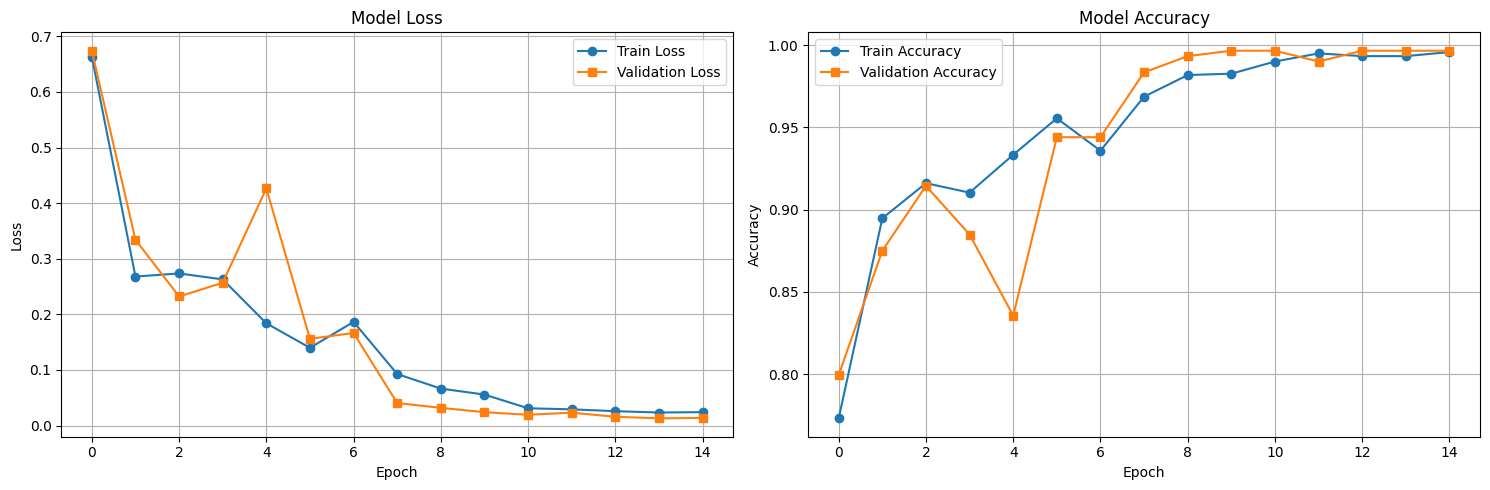

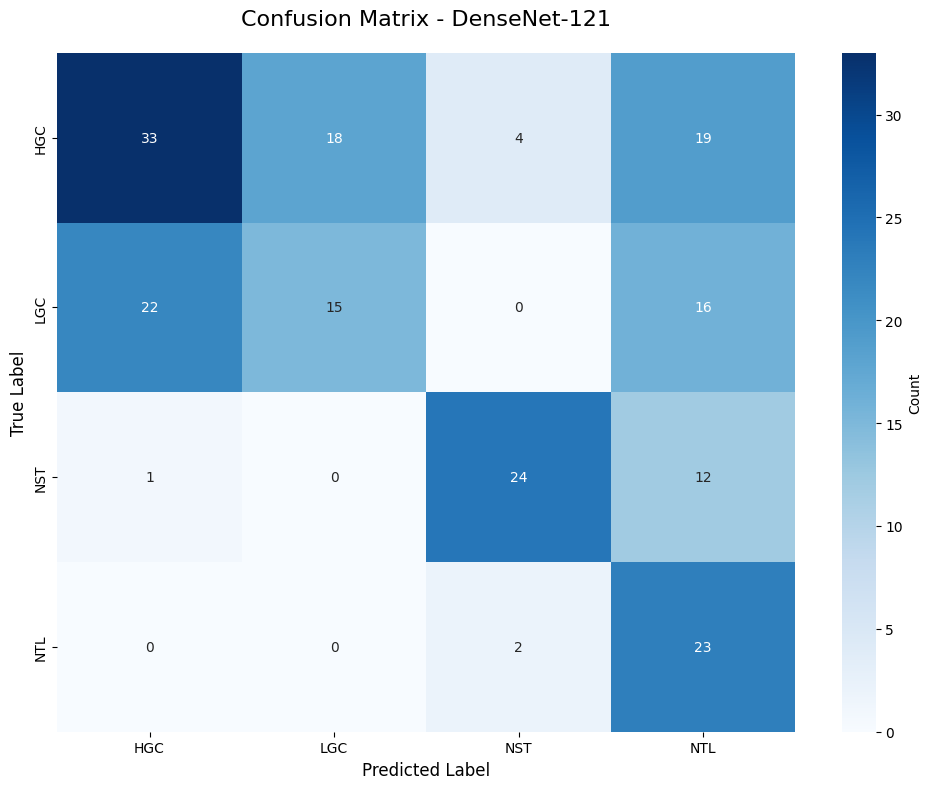

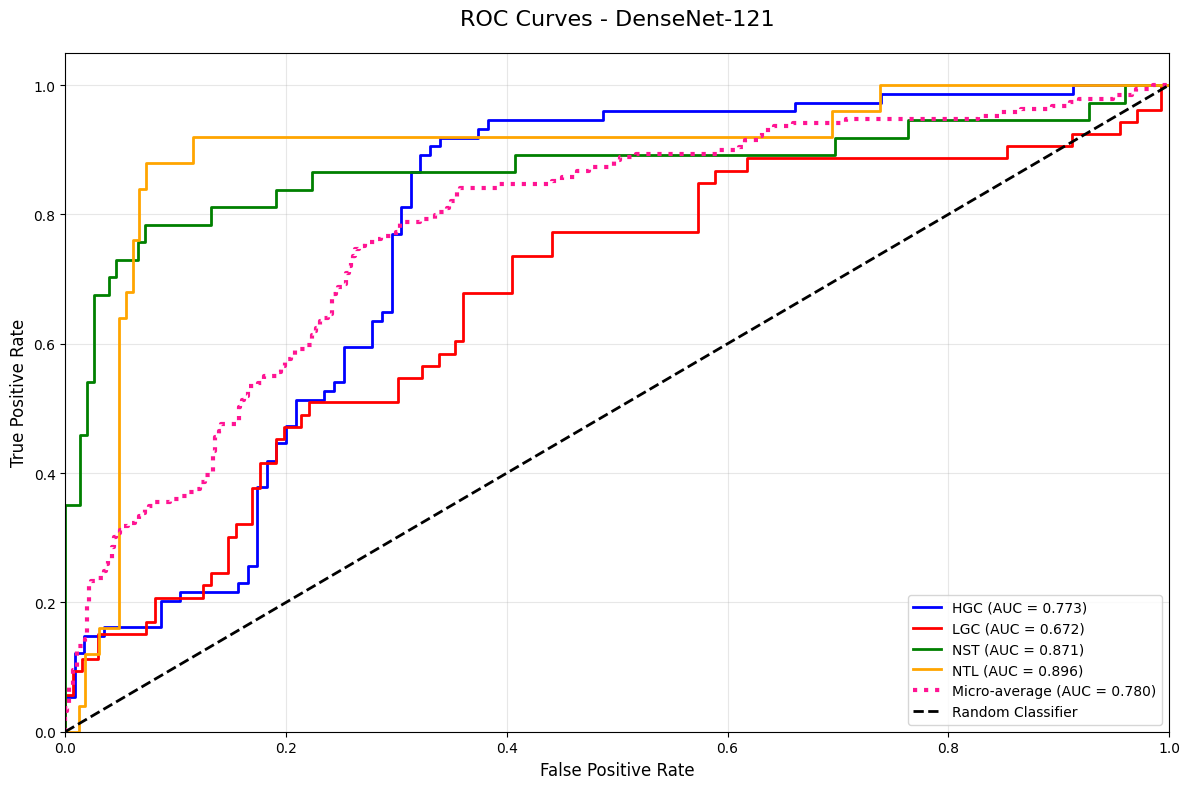


DenseNet-121 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training DenseNet-121")
print("=" * 80)

# Create model
densenet121 = create_densenet_model(architecture='121', num_classes=4, pretrained=True)

# Create trainer
trainer_121 = ModelTrainer(densenet121, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_121 = trainer_121.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DenseNet-121")

# Plot training history
trainer_121.plot_training_history(save_path='densenet121_training_history.png')

# Evaluate model
results_121 = trainer_121.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_121['confusion_matrix'], class_names, 'DenseNet-121',
                      save_path='densenet121_confusion_matrix.png')

# Plot ROC curves
roc_auc_121 = plot_roc_curves(results_121['labels'], results_121['probabilities'], class_names, 'DenseNet-121',
                              save_path='densenet121_roc_curves.png')
# Store results
results_121['model_name'] = 'DenseNet-121'
results_121['roc_auc'] = roc_auc_121
all_results.append(results_121)

print("\nDenseNet-121 training and evaluation complete!")

## Train DenseNet-201

Training DenseNet-201


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 213MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.16it/s, Loss=0.8586, Acc=0.7064]


Train Loss: 0.8586 Acc: 0.7064 Macro-F1: 0.6528


Val : 100%|██████████| 10/10 [00:01<00:00,  6.84it/s, Loss=1.4742, Acc=0.6447]


Val Loss: 1.4742 Acc: 0.6447 Macro-F1: 0.6213
✓ New best model saved with validation macro-F1: 0.6213

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.5085, Acc=0.8363]


Train Loss: 0.5085 Acc: 0.8363 Macro-F1: 0.7943


Val : 100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Loss=0.8207, Acc=0.7171]


Val Loss: 0.8207 Acc: 0.7171 Macro-F1: 0.6999
✓ New best model saved with validation macro-F1: 0.6999

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.16it/s, Loss=0.2986, Acc=0.8947]


Train Loss: 0.2986 Acc: 0.8947 Macro-F1: 0.8692


Val : 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Loss=0.2699, Acc=0.9013]


Val Loss: 0.2699 Acc: 0.9013 Macro-F1: 0.8751
✓ New best model saved with validation macro-F1: 0.8751

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.11it/s, Loss=0.2742, Acc=0.9128]


Train Loss: 0.2742 Acc: 0.9128 Macro-F1: 0.8867


Val : 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=0.5478, Acc=0.8224]


Val Loss: 0.5478 Acc: 0.8224 Macro-F1: 0.7844

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.19it/s, Loss=0.2313, Acc=0.9219]


Train Loss: 0.2313 Acc: 0.9219 Macro-F1: 0.8974


Val : 100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Loss=0.3233, Acc=0.8717]


Val Loss: 0.3233 Acc: 0.8717 Macro-F1: 0.8419

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.19it/s, Loss=0.2473, Acc=0.9243]


Train Loss: 0.2473 Acc: 0.9243 Macro-F1: 0.8999


Val : 100%|██████████| 10/10 [00:01<00:00,  6.98it/s, Loss=0.3397, Acc=0.8882]


Val Loss: 0.3397 Acc: 0.8882 Macro-F1: 0.8744

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.19it/s, Loss=0.1815, Acc=0.9326]


Train Loss: 0.1815 Acc: 0.9326 Macro-F1: 0.9226


Val : 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, Loss=0.6292, Acc=0.8059]


Val Loss: 0.6292 Acc: 0.8059 Macro-F1: 0.7560

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.1023, Acc=0.9671]


Train Loss: 0.1023 Acc: 0.9671 Macro-F1: 0.9622


Val : 100%|██████████| 10/10 [00:01<00:00,  6.90it/s, Loss=0.0516, Acc=0.9770]


Val Loss: 0.0516 Acc: 0.9770 Macro-F1: 0.9771
✓ New best model saved with validation macro-F1: 0.9771

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.21it/s, Loss=0.0456, Acc=0.9910]


Train Loss: 0.0456 Acc: 0.9910 Macro-F1: 0.9893


Val : 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=0.0366, Acc=0.9934]


Val Loss: 0.0366 Acc: 0.9934 Macro-F1: 0.9945
✓ New best model saved with validation macro-F1: 0.9945

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0408, Acc=0.9885]


Train Loss: 0.0408 Acc: 0.9885 Macro-F1: 0.9861


Val : 100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Loss=0.0344, Acc=0.9836]


Val Loss: 0.0344 Acc: 0.9836 Macro-F1: 0.9867

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0309, Acc=0.9901]


Train Loss: 0.0309 Acc: 0.9901 Macro-F1: 0.9899


Val : 100%|██████████| 10/10 [00:01<00:00,  6.89it/s, Loss=0.0286, Acc=0.9901]


Val Loss: 0.0286 Acc: 0.9901 Macro-F1: 0.9919

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0381, Acc=0.9893]


Train Loss: 0.0381 Acc: 0.9893 Macro-F1: 0.9892


Val : 100%|██████████| 10/10 [00:01<00:00,  6.96it/s, Loss=0.0303, Acc=0.9901]


Val Loss: 0.0303 Acc: 0.9901 Macro-F1: 0.9919

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0319, Acc=0.9901]


Train Loss: 0.0319 Acc: 0.9901 Macro-F1: 0.9910


Val : 100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Loss=0.0221, Acc=0.9934]


Val Loss: 0.0221 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0264, Acc=0.9918]


Train Loss: 0.0264 Acc: 0.9918 Macro-F1: 0.9899


Val : 100%|██████████| 10/10 [00:01<00:00,  6.89it/s, Loss=0.0211, Acc=0.9901]


Val Loss: 0.0211 Acc: 0.9901 Macro-F1: 0.9919

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.19it/s, Loss=0.0214, Acc=0.9967]


Train Loss: 0.0214 Acc: 0.9967 Macro-F1: 0.9964


Val : 100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Loss=0.0239, Acc=0.9901]


Val Loss: 0.0239 Acc: 0.9901 Macro-F1: 0.9919

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0191, Acc=0.9959]


Train Loss: 0.0191 Acc: 0.9959 Macro-F1: 0.9966


Val : 100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Loss=0.0191, Acc=0.9901]


Val Loss: 0.0191 Acc: 0.9901 Macro-F1: 0.9919

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.0225, Acc=0.9951]


Train Loss: 0.0225 Acc: 0.9951 Macro-F1: 0.9937


Val : 100%|██████████| 10/10 [00:01<00:00,  6.96it/s, Loss=0.0226, Acc=0.9901]


Val Loss: 0.0226 Acc: 0.9901 Macro-F1: 0.9919

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.17it/s, Loss=0.0235, Acc=0.9926]


Train Loss: 0.0235 Acc: 0.9926 Macro-F1: 0.9941


Val : 100%|██████████| 10/10 [00:01<00:00,  6.99it/s, Loss=0.0236, Acc=0.9901]


Val Loss: 0.0236 Acc: 0.9901 Macro-F1: 0.9919
Early stopping triggered after 18 epochs
Training complete in 4m 3s
Best validation macro-F1: 0.9948
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


Test Accuracy: 41.80%
Test Loss: 1.5630

Classification Report:
              precision    recall  f1-score   support

         HGC       0.61      0.38      0.47        74
         LGC       0.10      0.08      0.09        53
         NST       0.70      0.81      0.75        37
         NTL       0.28      0.68      0.40        25

    accuracy                           0.42       189
   macro avg       0.42      0.49      0.42       189
weighted avg       0.44      0.42      0.41       189


Confusion Matrix:
[[28 35  3  8]
 [13  4  5 31]
 [ 2  0 30  5]
 [ 3  0  5 17]]

ROC-AUC Scores:
Macro-average AUC: 0.7703
Micro-average AUC: 0.7589
HGC AUC: 0.7334
LGC AUC: 0.5974
NST AUC: 0.9342
NTL AUC: 0.8163


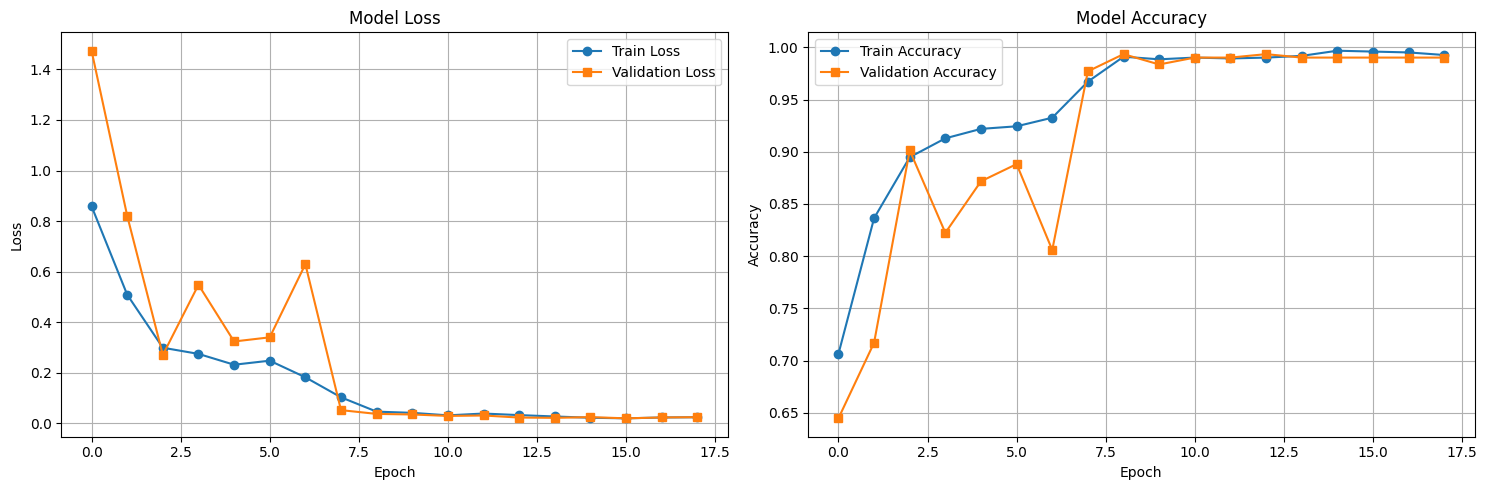

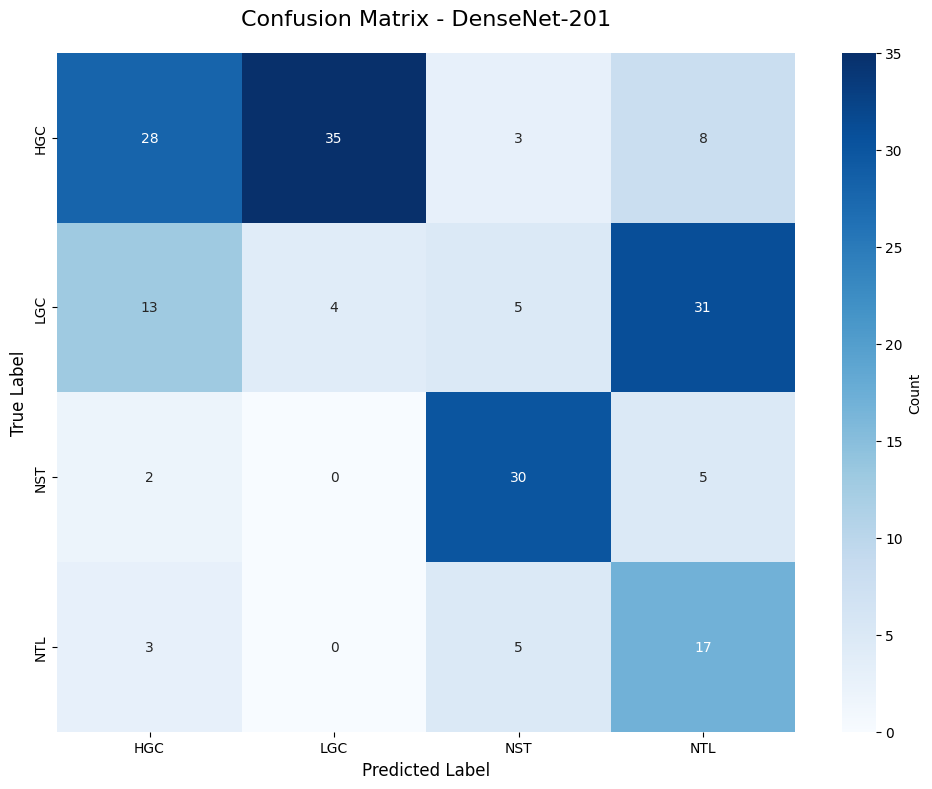

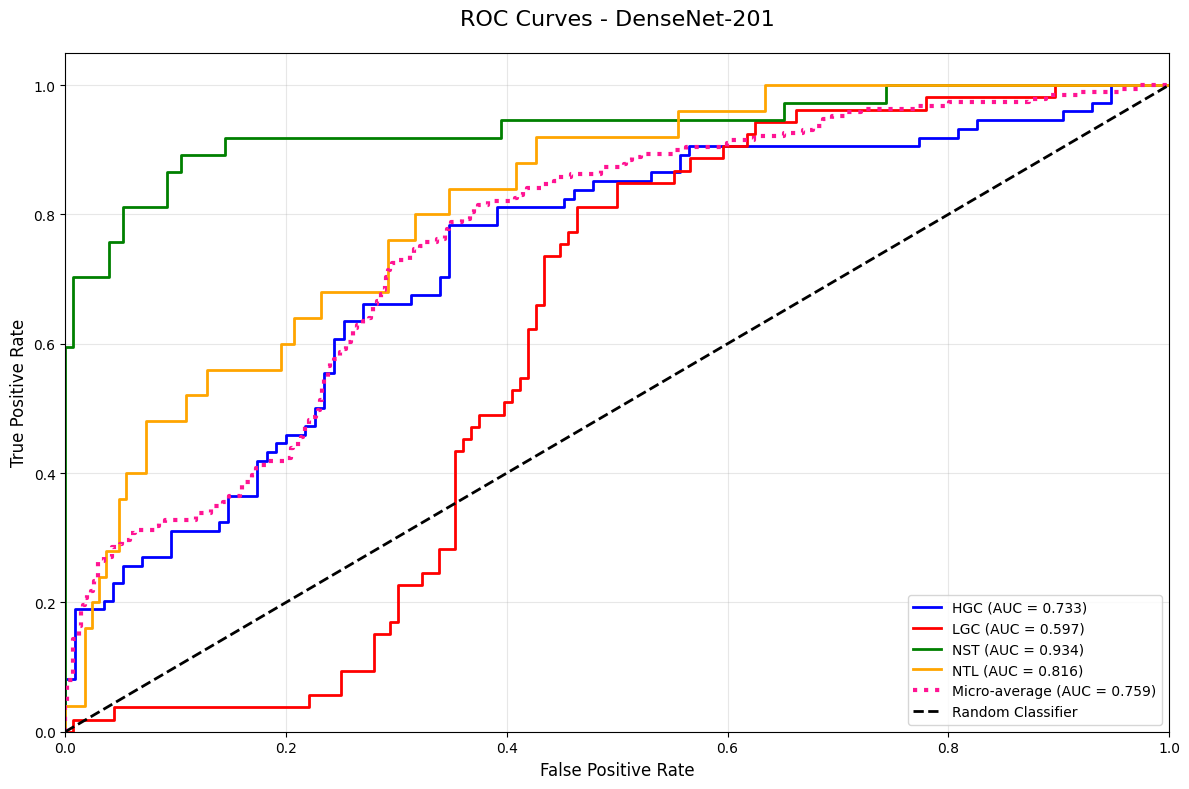


DenseNet-201 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training DenseNet-201")
print("=" * 80)

# Create model
densenet201 = create_densenet_model(architecture='201', num_classes=4, pretrained=True)

# Create trainer
trainer_201 = ModelTrainer(densenet201, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_201 = trainer_201.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DenseNet-201")

# Plot training history
trainer_201.plot_training_history(save_path='densenet201_training_history.png')

# Evaluate model
results_201 = trainer_201.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_201['confusion_matrix'], class_names, 'DenseNet-201',
                      save_path='densenet201_confusion_matrix.png')

# Plot ROC curves
roc_auc_201 = plot_roc_curves(results_201['labels'], results_201['probabilities'], class_names, 'DenseNet-201',
                               save_path='Densenet201_roc_curves.png')
# Store results
results_201['model_name'] = 'DenseNet-201'
results_201['roc_auc'] = roc_auc_201
all_results.append(results_201)

print("\nDenseNet-201 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DenseNet-121_201.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: DenseNet-121_201.csv

Metrics Summary:
          Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  DenseNet-121         50.264550      1.603606             0.543101          0.574403      0.514289                0.558266             0.502646         0.500901       0.589286    0.445946  0.507692         74.0       0.454545    0.283019  0.348837         53.0       0.800000    0.648649  0.716418         37.0       0.328571        0.92  0.484211         25.0   0.803077   0.780325  0.773090  0.672031  0.871088  0.896098      0.773090   